In [ ]:
!pip instal qiskit 
!pip install qiskit-optimization

ERROR: unknown command "instal" - maybe you meant "install"
     |████████████████████████████████| 154 kB 17.7 MB/s 
     |████████████████████████████████| 6.5 MB 64.6 MB/s 
     |████████████████████████████████| 634 kB 68.0 MB/s 
     |████████████████████████████████| 1.6 MB 48.0 MB/s 
     |████████████████████████████████| 943 kB 49.1 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 1.6 MB 60.5 MB/s 
     |████████████████████████████████| 37.5 MB 450 kB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 113 kB 26.2 MB/s 
  Created wheel for docplex: filename=docplex-2.22.213-py3-none-any.whl size=696882 sha256=a35310a7f70d55ccaeb161a70532b64841c223181095863eb5a4cba541dbdb16
  Stored in directory: /root/.cache/pip/wheels/90/69/6b/1375c68a5b7ff94c40263b151c86f58bd72200bf0c465b5ba3
  Created wheel for python-constraint: file

In [ ]:
import json
import time
from typing import List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.translators import from_docplex_mp

In [ ]:
with open('data_consumption.json') as json_file:
    data_consumption = json.load(json_file)

capacity_location = {"UK": {"solar": 11227.5, "onshore": 3082.8, "offshore": 8760.7}, "NI": {"solar": 334.9, "onshore": 1354.3, "offshore": 0}, "SC": {"solar": 353.9, "onshore": 8347.7, "offshore": 898.2}, "WA": {"solar": 1088.2, "onshore": 1313.1, "offshore": 724.0}}


In [ ]:
data_consumption

{'NI': 7177, 'SC': 22708.3, 'UK': 219924.9, 'WA': 13825.9}

In [ ]:
capacity_location

{'NI': {'offshore': 0, 'onshore': 1354.3, 'solar': 334.9},
 'SC': {'offshore': 898.2, 'onshore': 8347.7, 'solar': 353.9},
 'UK': {'offshore': 8760.7, 'onshore': 3082.8, 'solar': 11227.5},
 'WA': {'offshore': 724.0, 'onshore': 1313.1, 'solar': 1088.2}}

In [ ]:
locations = "UK,NI,SC,WA".split(",")
sources = "solar,onshore,offshore".split(",")
mdl = Model("ex5")

def create_variable(capacity_location):
  variables = {}
  for location, sources in capacity_location.items():
    variables[location] = {}
    for source in sources: 
      variables[location][source] = mdl.continuous_var(name=f"{location}_{source}")  
  return variables

def capacity_per_source(variables, sources):
  res = {}
  for source in sources: 
    res[source] = {}
  for location, sources in variables.items():
    for source, value in sources.items():
      res[source][location] = value
  return res
variables = create_variable(capacity_location)

location_capacity = {location: sum(sources.values()) for location, sources in variables.items()}
capacity_source = capacity_per_source(variables, sources)
avergae_source_demand = sum(data_consumption.values())/len(data_consumption)
lower_threshold, upper_threshold = 0.5, 1.5
cost_function = [(location_capacity[location] - data_consumption[location])**2 for location in locations] 
upper_constrains = [sum(capacity_source[source].values()) <= upper_threshold*avergae_source_demand for source in sources]
lower_constrains = [sum(capacity_source[source].values()) >= lower_threshold*avergae_source_demand for source in sources]

In [ ]:
sum(cost_function)



docplex.mp.quad.QuadExpr(UK_solar^2+2UK_solar*UK_onshore+2UK_solar*UK_offshore+UK_onshore^2+2UK_onshore*UK_offshore+UK_offshore^2+NI_solar^2+2NI_solar*NI_onshore+2NI_solar*NI_offshore+NI_onshore^2+2NI_onshore*NI_offshore+NI_offshore^2+SC_solar^2+2SC_solar*SC_onshore+2SC_solar*SC_offshore+SC_onshore^2+2SC_onshore*SC_offshore+SC_offshore^2+WA_solar^2+2WA_solar*WA_onshore+2WA_solar*WA_offshore+WA_onshore^2+2WA_onshore*WA_offshore+WA_offshore^2-439849.800UK_solar-439849.800UK_onshore-439849.800UK_offshore-14354NI_solar-14354NI_onshore-14354NI_offshore-45416.600SC_solar-45416.600SC_onshore-45416.600SC_offshore-27651.800WA_solar-27651.800WA_onshore-27651.800WA_offshore+49125293368.710)

In [ ]:
res = []

for location in locations:
  arr = []
  for source in sources:
    for source_ in sources:
      if source==source_:
        break;
      arr.append(variables[location][source] * variables[location][source_])
  res.append(sum(arr))
res

[docplex.mp.quad.QuadExpr(UK_solar*UK_onshore+UK_solar*UK_offshore+UK_onshore*UK_offshore),
 docplex.mp.quad.QuadExpr(NI_solar*NI_onshore+NI_solar*NI_offshore+NI_onshore*NI_offshore),
 docplex.mp.quad.QuadExpr(SC_solar*SC_onshore+SC_solar*SC_offshore+SC_onshore*SC_offshore),
 docplex.mp.quad.QuadExpr(WA_solar*WA_onshore+WA_solar*WA_offshore+WA_onshore*WA_offshore)]

In [ ]:
tmp

[]

In [ ]:
mdl.minimize(sum(cost_function) - sum(res))

#for lower_const in lower_constrains:
#  mdl.add_constraint(lower_const)
#  print(lower_const)
#for upper_const in upper_constrains:
#  mdl.add_constraint(upper_const)

In [ ]:
# load quadratic program from docplex model
qp = from_docplex_mp(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: ex5

Minimize
 obj: - 439849.799999999988 UK_solar - 439849.799999999988 UK_onshore
      - 439849.799999999988 UK_offshore - 14354 NI_solar - 14354 NI_onshore
      - 14354 NI_offshore - 45416.599999999999 SC_solar
      - 45416.599999999999 SC_onshore - 45416.599999999999 SC_offshore
      - 27651.799999999999 WA_solar - 27651.799999999999 WA_onshore
      - 27651.799999999999 WA_offshore + [ 2 UK_solar^2 + 2 UK_solar*UK_onshore
      + 2 UK_solar*UK_offshore + 2 UK_onshore^2 + 2 UK_onshore*UK_offshore
      + 2 UK_offshore^2 + 2 NI_solar^2 + 2 NI_solar*NI_onshore
      + 2 NI_solar*NI_offshore + 2 NI_onshore^2 + 2 NI_onshore*NI_offshore
      + 2 NI_offshore^2 + 2 SC_solar^2 + 2 SC_solar*SC_onshore
      + 2 SC_solar*SC_offshore + 2 SC_onshore^2 + 2 SC_onshore*SC_offshore
      + 2 SC_offshore^2 + 2 WA_solar^2 + 2 WA_solar*WA_onshore
      + 2 WA_solar*WA_offshore + 2 WA_onshore^2 + 2 WA_onshore*WA_offsho

In [ ]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO,
# or as a benchmark for the full problem.
#
# cplex = CplexOptimizer()

admm_params = ADMMParameters(
    rho_initial=1001, beta=1000, factor_c=900, maxiter=100, three_block=True, tol=1.0e-5
)

In [ ]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(
    params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer
)

# run ADMM to solve problem
result = admm.solve(qp)

In [ ]:
result

optimal function value: 48371805511.14843
optimal value: [561.43353213 563.03609395 564.34012957  19.38281165  19.38153089
  19.38025012  59.16668437  59.16540361  59.16412284  44.25136745
  44.52173562  45.24935483]
status: SUCCESS

In [ ]:
sum(result.x)

2058.4730170354933

In [ ]:
print("x={}".format(result.x))
print("fval={:.2f}".format(result.fval))

x=[561.43353213 563.03609395 564.34012957  19.38281165  19.38153089
  19.38025012  59.16668437  59.16540361  59.16412284  44.25136745
  44.52173562  45.24935483]
fval=48371805511.15


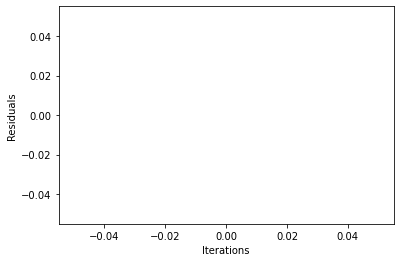

In [ ]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [ ]:
result.__dir__()


['_variables',
 '_variable_names',
 '_x',
 '_variables_dict',
 '_fval',
 '_raw_results',
 '_status',
 '_samples',
 '__module__',
 '__doc__',
 '__init__',
 'state',
 '__repr__',
 '__getitem__',
 'get_correlations',
 'x',
 'fval',
 'raw_results',
 'status',
 'variables',
 'variables_dict',
 'variable_names',
 'samples',
 '__dict__',
 '__weakref__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [ ]:
result._variable_names

['UK_solar',
 'UK_onshore',
 'UK_offshore',
 'NI_solar',
 'NI_onshore',
 'NI_offshore',
 'SC_solar',
 'SC_onshore',
 'SC_offshore',
 'WA_solar',
 'WA_onshore',
 'WA_offshore']